---
title: NerFs for SSH
date: 2023-08-09
subject: Neural Fields for SSH Interpolation
subtitle: Naive Nerfs applied to SSH Data
short_title: Spatial Data
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: data-assimilation, open-science
abbreviations:
    NerF: Neural Field
---

In [3]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import pandas as pd
import keras_core as keras
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn.pipeline import Pipeline


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a very simple spatial interpolation problem for sea surface height.

## Data

In [4]:
!ls /Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/

gf_mod_ssh_daily.nc       gf_obs_nadir.nc.dvc       natl_mod_ssh_daily.nc.dvc
gf_mod_ssh_daily.nc.dvc   gf_obs_nadirswot.nc       natl_mod_sst.nc.dvc
gf_mod_sst.nc             gf_obs_nadirswot.nc.dvc   natl_obs_nadir.nc.dvc
gf_mod_sst.nc.dvc         gf_obs_swot.nc            natl_obs_nadirswot.nc.dvc
gf_obs_nadir.nc           gf_obs_swot.nc.dvc


In [5]:
# import xarray as xr

# xrds = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_mod_ssh_daily.nc")
# xrds = xrds.sel(time=slice("2012-10-22","2012-12-22"))
# xrds = time_rescale(xrds, freq_dt=1, freq_unit="seconds", t0=None)
# xrds

In [6]:
import xarray as xr

xrds = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_mod_ssh_daily.nc")
xrds = xrds.sel(time=slice("2012-10-22","2012-10-22"))
xrds

<xarray.Dataset>
Dimensions:  (time: 1, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-22T12:00:00
Data variables:
    ssh      (time, lat, lon) float64 ...

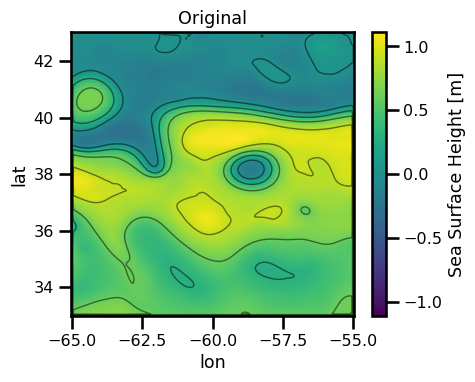

In [7]:
from matplotlib import ticker

fig, ax = plt.subplots(ncols=1, figsize=(5,4))

subset_ds = xrds.ssh.isel(time=0)

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds.plot.pcolormesh(ax=ax, cmap="viridis", cbar_kwargs=cbar_kwargs)

loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds.ssh.min().values, xrds.ssh.max().values)
subset_ds.plot.contour(
    ax=ax, 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--")
    # vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax.set(title="Original")

plt.tight_layout()
plt.show()

In [8]:
dfds = xrds["ssh"].to_dataframe().reset_index().dropna()
# apply coordinate transformation
dfds.head()

,time,lat,lon,ssh
0,2012-10-22 12:00:00,33.0,-65.00,0.0
1,2012-10-22 12:00:00,33.0,-64.95,0.0
2,2012-10-22 12:00:00,33.0,-64.90,0.0
3,2012-10-22 12:00:00,33.0,-64.85,0.0
4,2012-10-22 12:00:00,33.0,-64.80,0.0


In [9]:
from nerf4ssh._src.transforms.scaling import MinMaxDF

scaler = MinMaxDF(columns=["lon", "lat"])

x = scaler.fit_transform(dfds).values
y = dfds[["ssh"]].values

In [16]:
x.shape, y.shape

((40401, 2), (40401, 1))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *ReLU* activation function.

$$
\sigma(\mathbf{x}) = \text{ReLU}(\mathbf{x})
$$

In [52]:
# xrda["ssh_pre"] = (("time", "lat", "lon"), dm.data_to_df(out).to_xarray().ssh.data)

In [53]:
from nerf4ssh._src.losses import psnr

In [54]:
input_shape = (2,)
model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(1, activation=None),
    ]
)

In [55]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)               │        384 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_14 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_15 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 66,561 (260.00 KB)

 Trainable params: 66,561 (260.00 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:

verbose = 0

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [57]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [58]:
batch_size = 1024
epochs = 500
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.01, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [59]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [60]:
history_mlp = model.fit(
    x=x, y=y,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.3439 - psnr: 8.2327 - val_loss: 0.0191 - val_psnr: 18.7188
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3035 - psnr: 8.1320 - val_loss: 0.0846 - val_psnr: 10.9203
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2132 - psnr: 10.2620 - val_loss: 0.2907 - val_psnr: 5.5337
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1737 - psnr: 11.6423 - val_loss: 0.2148 - val_psnr: 7.0501
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1544 - psnr: 11.8128 - val_loss: 0.0653 - val_psnr: 12.3307
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1401 - psnr: 13.7751 - val_loss: 0.0384 - val_psnr: 14.7757
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1283 - psnr: 13.8410 - val_loss: 0.0474 - val_psnr: 13.9612
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1165 - psnr: 12.9877 - val_loss: 0.0242 - val_psnr: 17.1261
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44m

In [61]:
# model.save("saved_models/final_model_mlp.keras")

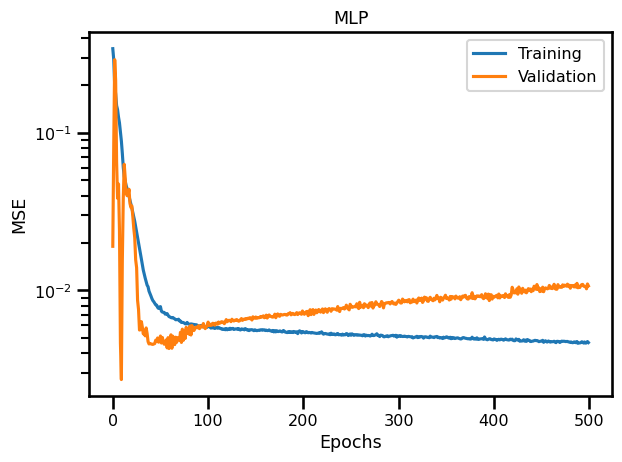

In [62]:
fig, ax = plt.subplots()

ax.plot(history_mlp.epoch, history_mlp.history['loss'], label="Training")
ax.plot(history_mlp.epoch, history_mlp.history['val_loss'], label="Validation")
ax.set(
    title="MLP",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
score = model.evaluate(x=x, y=y, verbose=1)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 0.0109 - psnr: 37.3185


In [64]:
predictions = model.predict(x=x)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step  


In [65]:
dfds["ssh_mlp"] = predictions

In [66]:
dfds.head()


,time,lat,lon,ssh,ssh_mlp
0,2012-10-22 12:00:00,33.0,-65.00,0.0,0.385913
1,2012-10-22 12:00:00,33.0,-64.95,0.0,0.407120
2,2012-10-22 12:00:00,33.0,-64.90,0.0,0.428083
3,2012-10-22 12:00:00,33.0,-64.85,0.0,0.449046
4,2012-10-22 12:00:00,33.0,-64.80,0.0,0.469890


In [67]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_mlp"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:  (time: 1, lat: 201, lon: 201)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22T12:00:00
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_mlp  (time, lat, lon) float32 0.3859 0.4071 0.4281 ... -0.111 -0.1116

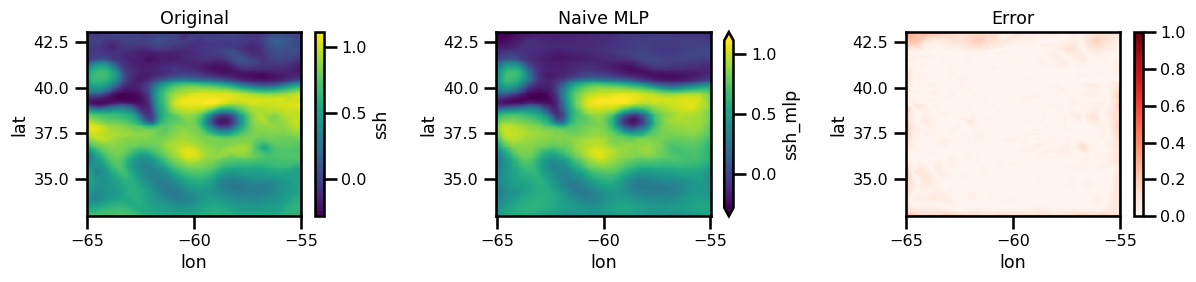

In [71]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

vmin = xrds_.ssh.min()
vmax = xrds_.ssh.max()

xrds_.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax, robust=False)
ax[0].set(title="Original")

xrds_.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax, robust=False)
ax[1].set(title="Naive MLP")

np.abs(xrds_.ssh_mlp-xrds_.ssh).isel(time=0).plot.pcolormesh(ax=ax[2], cmap="Reds", vmin=0.0, vmax=1.0)
ax[2].set(title="Error")

plt.tight_layout()
plt.show()

### Random Fourier Features

In [146]:
from nerf4ssh._src.models.rff import RFFLayer

In [147]:
input_shape = (2,)
model_rff = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        RFFLayer(num_features=512, length_scale_train=True),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation=None),
    ]
)

In [148]:

verbose = 0

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_rff_spatial_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [149]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [150]:
batch_size = 1024
epochs = 500
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.01, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [151]:
model_rff.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [152]:
history_rff = model_rff.fit(
    x=x, y=y,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2476 - psnr: 10.9303 - val_loss: 0.0079 - val_psnr: 23.8154
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0601 - psnr: 18.3219 - val_loss: 0.0140 - val_psnr: 21.7011
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0364 - psnr: 21.9884 - val_loss: 0.0102 - val_psnr: 23.7242
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0209 - psnr: 25.8299 - val_loss: 0.0101 - val_psnr: 26.9649
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0140 - psnr: 28.3913 - val_loss: 0.0061 - val_psnr: 28.5877
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109 - psnr: 29.8819 - val_loss: 0.0070 - val_psnr: 27.7154
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - psnr: 30.9974 - val_loss: 0.0049 - val_psnr: 29.2025
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0074 - psnr: 32.0313 - val_loss: 0.0049 - val_psnr: 29.3281
Epoch 9/500
36/36 ━━━━━━

In [153]:
# model.save("saved_models/final_model_mlp.keras")

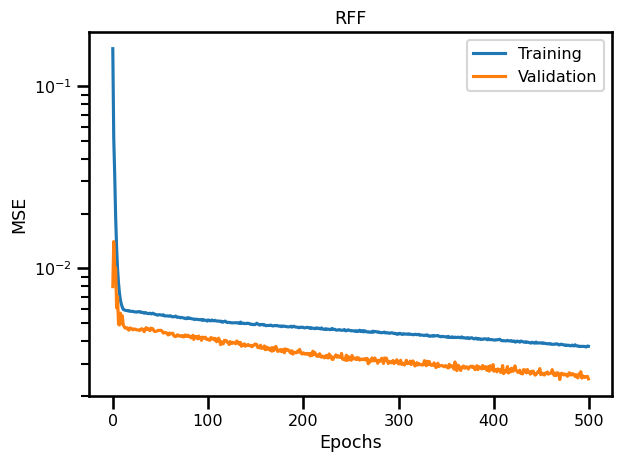

In [154]:
fig, ax = plt.subplots()

ax.plot(history_rff.epoch, history_rff.history['loss'], label="Training")
ax.plot(history_rff.epoch, history_rff.history['val_loss'], label="Validation")
ax.set(
    title="RFF",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [155]:
score = model_rff.evaluate(x=x, y=y, verbose=1)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - loss: 0.0084 - psnr: 38.7373


In [156]:
predictions = model_rff.predict(x=x)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step


In [157]:
dfds["ssh_rff"] = predictions

In [158]:
dfds.head()


,time,lat,lon,ssh,ssh_mlp,ssh_rff
0,2012-10-22 12:00:00,33.0,-65.00,0.0,0.385913,0.377152
1,2012-10-22 12:00:00,33.0,-64.95,0.0,0.407120,0.386689
2,2012-10-22 12:00:00,33.0,-64.90,0.0,0.428083,0.396390
3,2012-10-22 12:00:00,33.0,-64.85,0.0,0.449046,0.406042
4,2012-10-22 12:00:00,33.0,-64.80,0.0,0.469890,0.416328


In [159]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_mlp", "ssh_rff"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:  (time: 1, lat: 201, lon: 201)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22T12:00:00
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_mlp  (time, lat, lon) float32 0.3859 0.4071 0.4281 ... -0.111 -0.1116
    ssh_rff  (time, lat, lon) float32 0.3772 0.3867 0.3964 ... 0.02697 0.02762

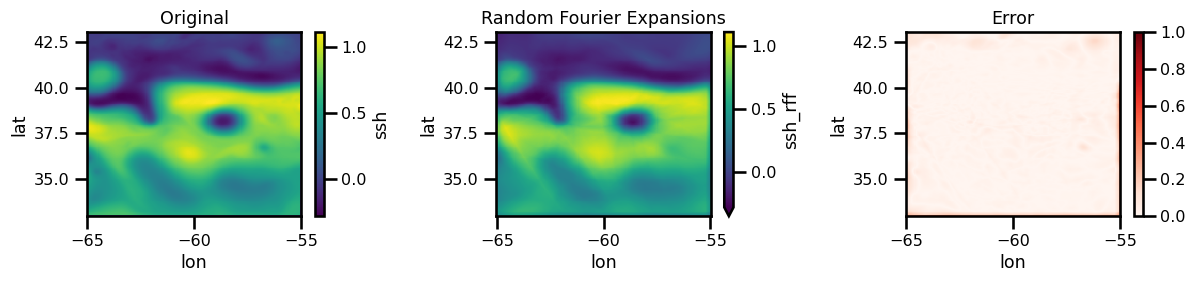

In [160]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

vmin = xrds_.ssh.min()
vmax = xrds_.ssh.max()

xrds_.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Original")

xrds_.ssh_rff.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Random Fourier Expansions")

np.abs(xrds_.ssh_rff-xrds_.ssh).isel(time=0).plot.pcolormesh(ax=ax[2], cmap="Reds", vmin=0.0, vmax=1.0)
ax[2].set(title="Error")

plt.tight_layout()
plt.show()

### SIREN

In [190]:
from nerf4ssh._src.models.siren import SirenLayer, SineInitializers

In [191]:
input_shape = (2,)
c = 6
omega_0 = 30
omega = 1.0
model_siren = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        SirenLayer(units=128, omega=omega_0, c=c, layer_type="first"),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        keras.layers.Dense(units=1, kernel_initializer=SineInitializers(c=c, omega=omega, layer_type="last"), activation=None),
        # SirenLayer(units=3, omega=omega, c=c, layer_type="last"),
    ]
)

In [192]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [193]:
batch_size = 32
epochs = 500
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.01, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [194]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_siren_spatial_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=5),
]

In [195]:
model_siren.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [196]:
history_siren = model_siren.fit(
    x=x, y=y,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0772 - psnr: 24.5940 - val_loss: 0.0893 - val_psnr: 16.0119
Epoch 2/500
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - loss: 0.0043 - psnr: 32.5882 - val_loss: 0.0872 - val_psnr: 16.1388
Epoch 3/500
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - loss: 0.0040 - psnr: 33.4322 - val_loss: 0.0854 - val_psnr: 16.2718
Epoch 4/500
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - loss: 0.0038 - psnr: 34.0531 - val_loss: 0.0832 - val_psnr: 16.4472
Epoch 5/500
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 0.0036 - psnr: 34.8126 - val_loss: 0.0820 - val_psnr: 16.6097
Epoch 6/500
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - loss: 0.0030 - psnr: 35.5460 - val_loss: 0.0785 - val_psnr: 16.8254
Epoch 7/500
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - loss: 0.0030 - psnr: 36.2412 - val_loss: 0.0779 - val_psnr: 16.8718
Epoch 8/500
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - loss: 0.0028 - psnr: 36.6274 - val_loss: 0.0778 - val_

In [197]:
# model.save("saved_models/final_model_mlp.keras")

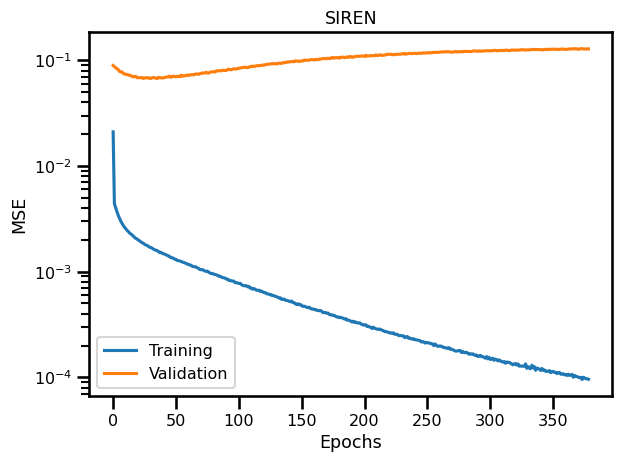

In [198]:
fig, ax = plt.subplots()

ax.plot(history_siren.epoch, history_siren.history['loss'], label="Training")
ax.plot(history_siren.epoch, history_siren.history['val_loss'], label="Validation")
ax.set(
    title="SIREN",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [199]:
score = model_siren.evaluate(x=x, y=y, verbose=1)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - loss: 7.0266e-04 - psnr: 48.1730


In [200]:
predictions = model_siren.predict(x=x)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


In [201]:
dfds["ssh_siren"] = predictions

In [202]:
dfds.head()


,time,lat,lon,ssh,ssh_mlp,ssh_rff,ssh_siren
0,2012-10-22 12:00:00,33.0,-65.00,0.0,0.385913,0.377152,-0.087909
1,2012-10-22 12:00:00,33.0,-64.95,0.0,0.407120,0.386689,0.093028
2,2012-10-22 12:00:00,33.0,-64.90,0.0,0.428083,0.396390,0.080100
3,2012-10-22 12:00:00,33.0,-64.85,0.0,0.449046,0.406042,0.023736
4,2012-10-22 12:00:00,33.0,-64.80,0.0,0.469890,0.416328,0.003799


In [203]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_mlp", "ssh_rff", "ssh_siren"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:    (time: 1, lat: 201, lon: 201)
Coordinates:
  * time       (time) datetime64[ns] 2012-10-22T12:00:00
  * lat        (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * lon        (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh        (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_mlp    (time, lat, lon) float32 0.3859 0.4071 0.4281 ... -0.111 -0.1116
    ssh_rff    (time, lat, lon) float32 0.3772 0.3867 0.3964 ... 0.02697 0.02762
    ssh_siren  (time, lat, lon) float32 -0.08791 0.09303 0.0801 ... 0.242 0.1996

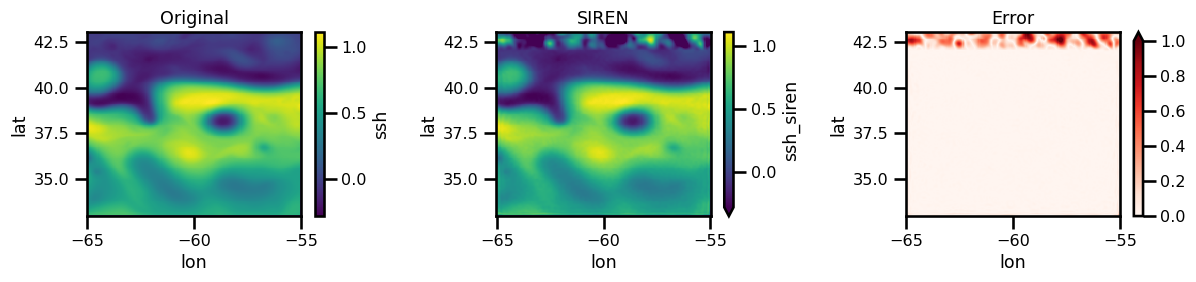

In [204]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

vmin = xrds_.ssh.min()
vmax = xrds_.ssh.max()

xrds_.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Original")

xrds_.ssh_siren.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="SIREN")

np.abs(xrds_.ssh_siren-xrds_.ssh).isel(time=0).plot.pcolormesh(ax=ax[2], cmap="Reds", vmin=0.0, vmax=1.0)
ax[2].set(title="Error")

plt.tight_layout()
plt.show()